# Information Value: Versión exacta

En esta notebook, vamos a ver la versión de IV sin shufflear texto, sino usando una fórmula cerrada que está en un apéndice del paper.

Para lo que queremos hacer, shufflear el texto **NO** es una opción por la cantidad de datos que tenemos.


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from __future__ import division, print_function
import pandas as pd
import numpy as np
import nltk
import math
from nltk.corpus import stopwords, gutenberg 
from iv_helpers import get_moby_dick_tokens

md_tokens = get_moby_dick_tokens()

fd = nltk.FreqDist(md_tokens)

Calculemos IV como en la anterior notebook

In [2]:
from scipy.stats import entropy
import random

window_size = 5000

def ocurrence_dataframe(tokenized_text, window_size):
    """
    Construye una matriz de ocurrencias dado un tamaño de ventana
    """
    freq = {}
    """
    N = Largo del texto
    P = Cantidad de ventanas
    """
    N = len(tokenized_text)
    P = int(math.ceil(N / window_size))

    for i in range(0, P):
        """
        Para cada ventana: hago un Fdist de la ventana, y lo sumo a las palabras que ya tenga
        """
        lower_bound, upper_bound = window_size * i, min(window_size* (i+1), N) 
        window = tokenized_text[lower_bound:upper_bound]
        window_fdist = nltk.FreqDist(window)

        for word in window_fdist:
            if word not in freq:
                freq[word] = [0] * P
                
            freq[word][i] = window_fdist[word]
            
    df = pd.DataFrame.from_dict(freq, orient="index")
    
    df["entropy"] = df.apply(entropy, axis=1, raw=True)
    df["total"] = df[range(P)].apply(sum, axis=1, raw=True)
    df["freq"] = df["total"] / len(tokenized_text)
    df["not_stop_word"] = df.index.map(lambda w: w not in stopwords.words('english'))
    
    return df

occurrence_df = ocurrence_dataframe(md_tokens, window_size)

# Shuffleo Texto
shuffled_text = random.shuffle(md_tokens)
shuffled_df = ocurrence_dataframe(md_tokens, window_size)
#
occurrence_df["shuffled_entropy"] = shuffled_df["entropy"]
occurrence_df["information_value"] = occurrence_df.freq * (occurrence_df.shuffled_entropy - occurrence_df.entropy)

occurrence_df.sort_values("information_value", ascending=False, inplace=True)


# Cálculo de Information Value sin usar un shuffle de texto

El cálculo hecho depende de un shuffle particular del texto. Según Zanette y Montemurro, hay una forma cerrada para la esperanza de la entropía de una palabra sobre un shuffle cualquiera de texto.

La forma cerrada es

\begin{equation}
    H(J| w) = -P \sum_{m=1}^{min(n, N/P)} p(m) \frac{m}{n} log \frac{m}{n}
\end{equation}

donde $N$ cantidad total de tokens del texto, $P$ "cantidad de capítulos" (asumiendo que todas las secciones tienen igual cantidad de tokens), $n$ la cantidad total de apariciones de $w$ en todo el texto. y $p(m)$ la función de densidad de una Hipergeométrica de Parámetros $N, n, N/P$ 

In [3]:
from scipy.stats import hypergeom

def exact_hypergeom(k, M, N, n):
    hv = hypergeom(M=M, N=N, n=n)
    
    return hv.pmf(k)


def exact_shuffled_entropy(word_series, no_tokens, window_size, hypergeom=exact_hypergeom):
    """
    Calculates exact shuffled entropy 
    
    Parameters
    ----------
    
    word_series: pandas.Series
        row of a dataframe built with occurrence_dataframe function
    no_tokens: int
        Number of tokens (N) in text
    window_size: int
        Number of tokens per window
    hypergeom: function with parameters k, M, N, n
        Function calculating the mass function of a Hypergeometric with parameters M, N, n
    """
    
    
    log = open("exact.log", "a")
    N = len(md_tokens)
    P = int(math.ceil(N / window_size))

    n = word_series.total

    sum_range = xrange(1, min(int(n), window_size)+1)
    pmfs = []
    ents = []
    for m in sum_range:
        p = hypergeom(m, M=N, N=window_size, n=n)
        pmfs.append(p)
        ents.append( (m/n) * np.log2(m/n))
        
    # Lo calculo así a ver si resuelvo algún problema numérico...
    shuffled_entropy = -P * np.array(pmfs).dot(ents)
    sum_of_pmfs = sum(pmfs)
    
    if sum_of_pmfs < 0.95:
        print("="*80, file=log)
        print("PROBLEM HERE", file=log)
        print(word_series, file=log)
        print("Hypergeometric with {} total balls, {} drawns, and {} black balls".format(N, window_size, n), file=log)
        print("sum of pmfs = {}".format(sum_of_pmfs), file=log)
    
    log.close()
    
    return shuffled_entropy

fn = lambda w: exact_shuffled_entropy(w, len(md_tokens), window_size)

occurrence_df["exact_shuffled_entropy"] = occurrence_df.apply(fn, axis=1)

Bueno,hay algunas cosas raras. Pueden deberse a errores numéricos! Observemos que las sumas de las pmfs ni siquiera dan cerca de 1...


Veamos que este cálculo no cambia nada sustancialmente. Hagamos un histograma de las diferencias

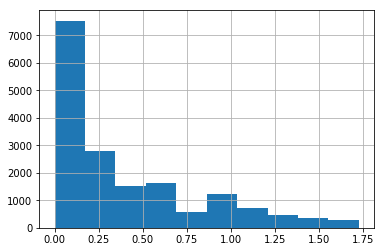

In [4]:
diff = (occurrence_df["exact_shuffled_entropy"] - occurrence_df["shuffled_entropy"])

diff.hist();

In [5]:
occurrence_df["exact_information_value"] = occurrence_df.freq *\
    (occurrence_df.exact_shuffled_entropy - occurrence_df.entropy)

occurrence_df.sort_values("exact_information_value", ascending=False, inplace=True)
relevant_cols = [c for c in occurrence_df.columns if c not in range(42)] 
occurrence_df.iloc[:40][relevant_cols]

,entropy,total,freq,not_stop_word,shuffled_entropy,information_value,exact_shuffled_entropy,exact_information_value
the,3.726940,14431,0.068905,False,3.735913,0.000618,5.401096,0.115358
of,3.709943,6609,0.031557,False,3.734602,0.000778,5.398667,0.053290
and,3.729945,6430,0.030702,False,3.734612,0.000143,5.398542,0.051229
to,3.730306,4625,0.022083,False,3.733356,0.000067,5.396742,0.036801
in,3.715654,4172,0.019920,False,3.730782,0.000301,5.396045,0.033474
that,3.723710,3085,0.014730,False,3.728832,0.000075,5.393538,0.024597
his,3.694612,2530,0.012080,False,3.729971,0.000427,5.391424,0.020498
it,3.711352,2522,0.012042,False,3.725218,0.000167,5.391386,0.020231
he,3.655996,1896,0.009053,False,3.729676,0.000667,5.387488,0.015675
is,3.592272,1725,0.008237,False,3.725826,0.001100,5.385929,0.014774


In [6]:
entropy(occurrence_df[range(42)].loc["the"])

3.7269400299830697

Si sacamos los stop words tiene algo de sentido todo, pero no debería tener que pasar esto

In [7]:
occurrence_df[occurrence_df.not_stop_word][:50][relevant_cols]


,entropy,total,freq,not_stop_word,shuffled_entropy,information_value,exact_shuffled_entropy,exact_information_value
whale,3.437954,1226,0.005854,True,3.719810,0.001650,5.378879,0.011362
one,3.709246,921,0.004398,True,3.722070,0.000056,5.370775,0.007307
ahab,3.129364,511,0.002440,True,3.694476,0.001379,5.344385,0.005404
like,3.685124,647,0.003089,True,3.700966,0.000049,5.356896,0.005165
ye,3.230246,472,0.002254,True,3.680344,0.001014,5.339441,0.004754
upon,3.683538,566,0.002703,True,3.702372,0.000051,5.350181,0.004504
ship,3.569239,518,0.002473,True,3.690504,0.000300,5.345192,0.004393
man,3.635437,527,0.002516,True,3.698975,0.000160,5.346198,0.004305
old,3.570512,450,0.002149,True,3.682584,0.000241,5.336265,0.003794
sea,3.595886,455,0.002173,True,3.676818,0.000176,5.337014,0.003783


El orden da ligeramente distinto... y además podemos ver que la diferencia siempre es en favor del promedio. ¿Estará bien la cuenta?

# Lo mismo, pero con una aproximación a la hipergeométrica



In [8]:
from scipy.stats import poisson

def poisson_approx(k, M, n, N):
    return poisson.pmf(k, mu=(n*N)/float(M))

fn = lambda w: exact_shuffled_entropy(w, len(md_tokens), window_size, poisson_approx)

occurrence_df["poisson_shuffled_entropy"] = occurrence_df.apply(fn, axis=1)

In [15]:
occurrence_df["poisson_information_value"] = occurrence_df.freq *\
    (occurrence_df.poisson_shuffled_entropy - occurrence_df.entropy)

occurrence_df.sort_values("poisson_information_value", ascending=False, inplace=True)

occurrence_df.iloc[:40][occurrence_df.columns.difference(range(42))]

,entropy,exact_information_value,exact_shuffled_entropy,freq,information_value,not_stop_word,poisson_information_value,poisson_shuffled_entropy,shuffled_entropy,total
the,3.726940,0.115358,5.401096,0.068905,0.000618,False,0.115345,5.400905,3.735913,14431
of,3.709943,0.053290,5.398667,0.031557,0.000778,False,0.053283,5.398416,3.734602,6609
and,3.729945,0.051229,5.398542,0.030702,0.000143,False,0.051221,5.398288,3.734612,6430
to,3.730306,0.036801,5.396742,0.022083,0.000067,False,0.036794,5.396444,3.733356,4625
in,3.715654,0.033474,5.396045,0.019920,0.000301,False,0.033468,5.395731,3.730782,4172
that,3.723710,0.024597,5.393538,0.014730,0.000075,False,0.024591,5.393162,3.728832,3085
his,3.694612,0.020498,5.391424,0.012080,0.000427,False,0.020493,5.390996,3.729971,2530
it,3.711352,0.020231,5.391386,0.012042,0.000167,False,0.020226,5.390958,3.725218,2522
he,3.655996,0.015675,5.387488,0.009053,0.000667,False,0.015670,5.386966,3.729676,1896
is,3.592272,0.014774,5.385929,0.008237,0.001100,False,0.014769,5.385369,3.725826,1725


Pasa lo mismo con los stop words acá

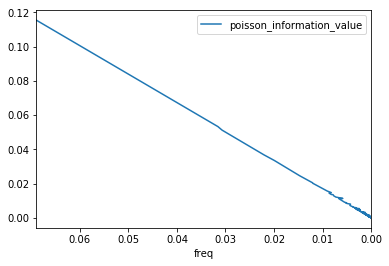

In [22]:
occurrence_df.plot(y="poisson_information_value", x="freq")

Acá vemos que con la frecuencia baja el information value! Esto está mal, hay un problema en la cuenta seguramente

In [10]:
occurrence_df[occurrence_df.not_stop_word][:50][relevant_cols]

,entropy,total,freq,not_stop_word,shuffled_entropy,information_value,exact_shuffled_entropy,exact_information_value
whale,3.437954,1226,0.005854,True,3.719810,0.001650,5.378879,0.011362
one,3.709246,921,0.004398,True,3.722070,0.000056,5.370775,0.007307
ahab,3.129364,511,0.002440,True,3.694476,0.001379,5.344385,0.005404
like,3.685124,647,0.003089,True,3.700966,0.000049,5.356896,0.005165
ye,3.230246,472,0.002254,True,3.680344,0.001014,5.339441,0.004754
upon,3.683538,566,0.002703,True,3.702372,0.000051,5.350181,0.004504
ship,3.569239,518,0.002473,True,3.690504,0.000300,5.345192,0.004393
man,3.635437,527,0.002516,True,3.698975,0.000160,5.346198,0.004305
old,3.570512,450,0.002149,True,3.682584,0.000241,5.336265,0.003794
sea,3.595886,455,0.002173,True,3.676818,0.000176,5.337014,0.003783


# En nuestro caso...


In [11]:
import re
from scipy.stats import entropy

df = pd.read_csv("../contrastes/provincias.csv", quotechar="\"", decimal=",")

df = df.set_index("palabra")


fnorm_vars = [c for c in df.columns if re.match(r'fnorm_.*', c)]
cant_palabras = [c for c in df.columns if re.match(r'.*Palabras', c)]


In [12]:
"""
Método que calcula la entropía de una palabra (usando df)
"""

import math


def w_entropy(df, word):
    # Esto es porque se mambea con los tipos (creo)
    vec = df.loc[word][cant_palabras].tolist()
    
    return entropy(vec)

entropy([1] * 10000)

9.2103403719761801

In [13]:
from scipy.stats import hypergeom

word = "anga"

n = df.loc[word].cantPalabra
N = df.cantPalabra.sum()
P = 23 # cantidad de provincias

hv = hypergeom(M=N, N=N/P, n=n)

shuffled_entropy = -P * sum([hv.pmf(m) * (float(m)/n) * np.log2(float(m)/n) for m in xrange(1, min(n, N  / P))])

print shuffled_entropy

SyntaxError: invalid syntax (<ipython-input-13-a776c7fe7529>, line 13)

In [ ]:
import numpy as np

def expected_random_shuffle(df, word):
    """
    Apéndice último del paper de Zanette
    """
    n = df.loc[word].cantPalabra
    N = df.cantPalabra.sum()
    P = 23 # cantidad de provincias

    hv = hypergeom(M=N, N=N/P, n=n)

    return -P * sum([hv.pmf(m) * (float(m)/n) * np.log2(float(m)/n) for m in xrange(1, min(n, N  / P))])

    

def information_value(df, word):
    
    vec = df.loc[word][cant_palabras].tolist()
    n = sum(vec)
    
    freq = float(df.loc[word].cantPalabra) / (df.cantPalabra.sum())
    word_entropy = w_entropy(df, word)
    
    shuffled_entropy = expected_random_shuffle(df, word)

    #print(word)
    #print("entropía = {} entropía shuffle = {}".format(word_entropy, shuffled_entropy))

    res = np.log2(1+freq) * (shuffled_entropy - word_entropy) 
    
    return res
    

In [ ]:
test_words = [
    "anga",
    "culiaw",
    "despues",
    "mitai",
    "artante",
    "q",
    "como",
    "ver",
    "de",
    "nah"]

for word in test_words:
    print word, information_value(df,word)

In [ ]:
df["iv"] = map(lambda word: information_value(df, word), df.index)
df["entropy"] = map(lambda word: w_entropy(df, word), df.index)

In [ ]:
df = df.sort(columns="entropy")

In [ ]:
df[df.cantPalabra > 150][["entropy", "iv", "cantPalabra", "provinciaFnormMax"]].to_csv("prueba.csv")